# Node classification using :


## 1- MLP

<p>This work used two datasets, Cora dataset and Facebook Page-page dataset</p>

In [1]:
###n import libraries ###
from torch_geometric.datasets import Planetoid, FacebookPagePage
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from torch_geometric.utils import to_dense_adj

In [2]:
### Load the Cora dataset ###
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
print(f'Dataset: {dataset}')
print(f"number of graphs: {len(dataset)}")
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Node feature matrix shape: {data.x.shape}')
print(f"Edge index : {data.edge_index}")

Dataset: Cora()
number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Node feature matrix shape: torch.Size([2708, 1433])
Edge index : tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


In [3]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


<h5>Graph Analysis</h5>

In [3]:
print(f'Graph :')
print('-----------------------------')
print(f'Edges are directed : {data.is_directed()}')
print(f'Graph has isolated nodes : {data.has_isolated_nodes()}')
print(f'Graph has self loops : {data.has_self_loops()}')
print(f'Graph is bipartite : {data.is_bipartite()}')
print(f'Graph is undirected : {data.is_undirected()}')
# print(f'Graph is heterogenous : {data.is_heterogeneous()}')
# print(f'Graph is homogeneous : {data.is_homogeneous()}')

Graph :
-----------------------------
Edges are directed : False
Graph has isolated nodes : False
Graph has self loops : False
Graph is bipartite : False
Graph is undirected : True


In [ ]:
    ### Convert the objct to a DataFrame ###
    ### Node features ###
    df_x = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
    ### Node labels ###
    df_x['label'] = pd.DataFrame(data.y)
    

In [19]:
### print node_features and labels###
df_x.to_csv('node_features.csv', index=False)
df_x.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_1424,feature_1425,feature_1426,feature_1427,feature_1428,feature_1429,feature_1430,feature_1431,feature_1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
### Edge features ###
edge_index = data.edge_index.numpy()
edge_index_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
edge_index_df.to_csv('edge_index.csv', index=False)
edge_index_df.head()

,source,target
0,633,0
1,1862,0
2,2582,0
3,2,1
4,652,1


In [6]:
data.train_mask = range(1400)
data.val_mask = range(1401, 2000)
data.test_mask = range(2001, 2708)

In [7]:
### Let's define a metric the classifaction  ###

def accuracy(y_pred, y_true):
    preds = y_pred.argmax(dim=1)
    correct = (preds == y_true).sum()
    return correct.float() / len(y_true)

In [8]:
### Create MLP class ###
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, dim_in, dim_hid, dim_out):
        super().__init__()
        self.fc1 = Linear(dim_in, dim_hid)
        self.fc2 = Linear(dim_hid, dim_out)

        # Initialize history for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    ### Training function with history tracking ###
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()

        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Track losses and accuracy
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy(out[data.val_mask], data.y[data.val_mask]).item()

            self.train_losses.append(loss.item())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss.item():.3f}, Val Loss: {val_loss:.2f}, Val Acc: {val_acc*100:.2f}%')

    ### Evaluate the model ###
    def evaluate(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        return acc.item()

    ### Plot Loss ###
    def plot_loss(self):
        plt.figure(figsize=(8,5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

    ### Plot Accuracy ###
    def plot_accuracy(self):
        plt.figure(figsize=(8,5))
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy Curve')
        plt.legend()
        plt.show()

    ### Plot ROC AUC ###    
    def plot_roc_auc(self, data):
        self.eval()
        out = self(data.x)
        y_true = data.y[data.test_mask].numpy()
        y_scores = out[data.test_mask].detach().numpy()
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8,5))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()


In [9]:
### Create MLP instance ###

mlp = MLP (dataset.num_features, 16, dataset.num_classes)
print(mlp)

MLP(
  (fc1): Linear(in_features=1433, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=7, bias=True)
)


In [10]:
mlp.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.923, Val Loss: 1.92, Val Acc: 11.69%
Epoch  20 | Train Loss: 0.362, Val Loss: 0.81, Val Acc: 75.96%
Epoch  40 | Train Loss: 0.067, Val Loss: 0.73, Val Acc: 75.63%
Epoch  60 | Train Loss: 0.047, Val Loss: 0.73, Val Acc: 75.63%
Epoch  80 | Train Loss: 0.042, Val Loss: 0.73, Val Acc: 75.79%
Epoch 100 | Train Loss: 0.036, Val Loss: 0.74, Val Acc: 76.63%


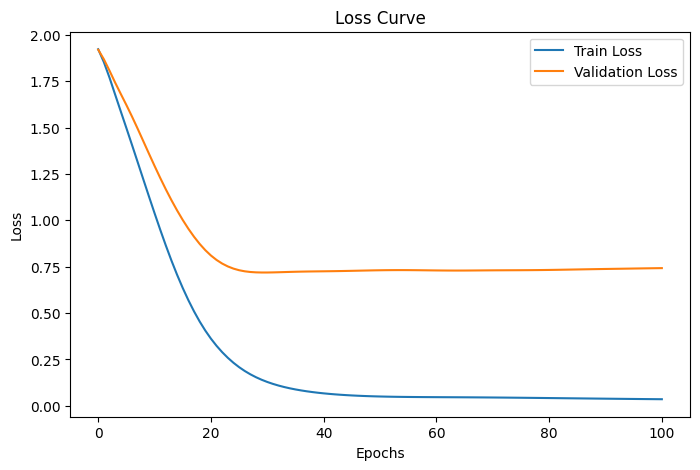

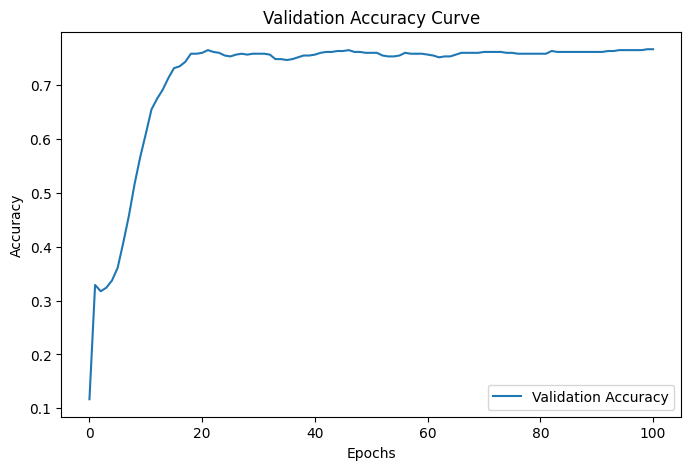

In [11]:
import matplotlib.pyplot as plt
mlp.plot_loss()
mlp.plot_accuracy()

In [12]:
acc = mlp.evaluate(data)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 71.29%


## Facebook Page-Page dataset

In [12]:
### Let's Load the Facebook dataset ###
dataset = FacebookPagePage(root='.')
data1 = dataset[0]

In [13]:
### Dataset Analysis ###
print(f'Dataset: {dataset}')
print(f'Number of Graph: {len(dataset)}')
print(f'Number of nodes: {data1.num_nodes}')
print(f'Number of edges: {data1.num_edges}')
print(f'Number of features: {data1.num_features}')
print(f'Number of classes: {dataset1.num_classes}')
print(f'Node feature matrix shape: {data1.x.shape}')

Dataset: FacebookPagePage()
Number of Graph: 1
Number of nodes: 22470
Number of edges: 342004
Number of features: 128
Number of classes: 4
Node feature matrix shape: torch.Size([22470, 128])


In [17]:
print(f'Graph :')
print('-----------------------------')
print(f'Edges are directed : {data1.is_directed()}')
print(f'Graph has isolated nodes : {data1.has_isolated_nodes()}')
print(f'Graph has self loops : {data1.has_self_loops()}')
print(f'Graph is bipartite : {data1.is_bipartite()}')
print(f'Graph is undirected : {data1.is_undirected()}')

Graph :
-----------------------------
Edges are directed : False
Graph has isolated nodes : False
Graph has self loops : True
Graph is bipartite : False
Graph is undirected : True


In [18]:
    ### Convert the objct to a DataFrame ###
    ### Node features ###
    df_x = pd.DataFrame(data1.x.numpy(), columns=[f'feature_{i}' for i in range(data1.x.shape[1])])
    ### Node labels ###
    df_x['label'] = pd.DataFrame(data1.y)

In [19]:
df_x.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,label
0,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,0
1,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.234818,-0.223700,-0.284379,-0.197935,-0.147256,-0.255755,-0.21514,-0.364134,-0.128634,2
2,-0.262576,-0.265053,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.210461,-0.25101,3.222161,...,-0.273229,-0.223700,-0.284379,-0.224216,-0.209509,-0.255755,-0.21514,-0.375903,-0.223836,1
3,-0.246378,-0.276483,-0.241991,-0.299327,-0.299159,-0.270681,-0.307051,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.223700,-0.265534,-0.080353,-0.209509,-0.250560,-0.18026,-0.375903,-0.223836,2
4,-0.262576,-0.276483,-0.262350,-0.299327,-0.299159,-0.270681,-0.307757,-0.269733,-0.25101,-0.308343,...,-0.273229,-0.175312,-0.272613,-0.224216,-0.181153,-0.255755,-0.21514,-0.370639,-0.223836,3


In [20]:
data1.train_mask = range(18000)
data1.val_mask = range(18001, 20000)
data1.test_mask = range(20001, 22470)

In [21]:
mlp1 = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp1)

MLP(
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=4, bias=True)
)


Epoch   0 | Train Loss: 1.442, Val Loss: 1.45, Val Acc: 25.46%
Epoch  20 | Train Loss: 0.671, Val Loss: 0.69, Val Acc: 72.99%
Epoch  40 | Train Loss: 0.581, Val Loss: 0.62, Val Acc: 74.79%
Epoch  60 | Train Loss: 0.552, Val Loss: 0.61, Val Acc: 75.24%
Epoch  80 | Train Loss: 0.535, Val Loss: 0.60, Val Acc: 75.64%
Epoch 100 | Train Loss: 0.522, Val Loss: 0.61, Val Acc: 75.74%


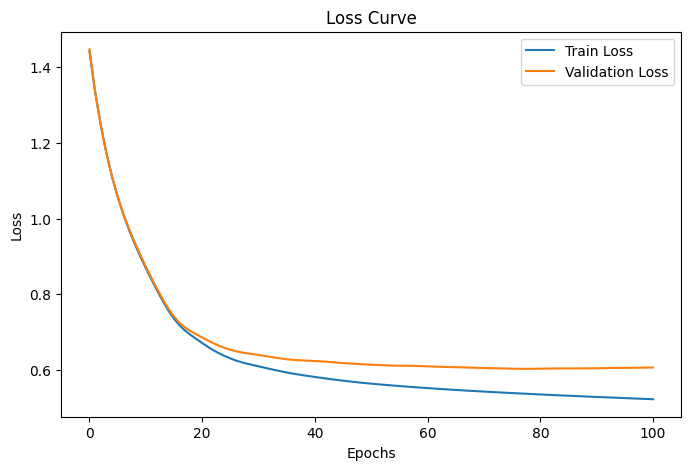

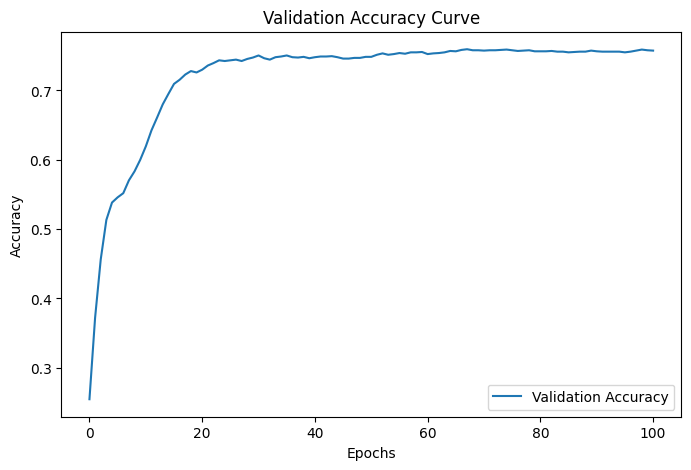

In [22]:
### Let's train the Facebook dataset ###
mlp1.fit(data1, epochs=100)

mlp1.plot_loss()
mlp1.plot_accuracy()

In [23]:
acc = mlp1.evaluate(data1)
print(f'Test Accuracy: {acc * 100:.2f}%')

Test Accuracy: 74.73%


## 2 - Vanilla Neural Network Implementation

In [13]:
### Create Vanilla GNN class ###

class VanillaGNNLayer (nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias = False)

    def forward(self, x, adjency):
        x = self.linear(x)
        x = torch.sparse.mm(adjency, x)
        return x

<h5>Let's convert the edge index in coordinate format to a dense adjency matrix, note that the adgency matrix is useful because in maintain the connections between every node in the graph</h5>

In [14]:
adjancy = to_dense_adj(data.edge_index)[0]
adjancy + torch.eye(len(adjancy))
adjancy

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [16]:
class VanillaGNN(nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

        # Initialize history for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x, adjancy):
        h = self.gnn1(x, adjancy)
        h = torch.relu(h)
        h = self.gnn2(h, adjancy)
        return F.log_softmax(h, dim=1)


    ### Training function with history tracking ###lo
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay = 5e-4)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad() # clear the gradients
            out = self(data.x, adjancy)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Track losses and accuracy
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy(out[data.val_mask], data.y[data.val_mask]).item()

            self.train_losses.append(loss.item())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss.item():.3f}, Val Loss: {val_loss:.2f}, Val Acc: {val_acc*100:.2f}%')

    ### Evaluate the model ###
    def evaluate(self, data):
        self.eval()
        out = self(data.x, adjancy)
        acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        return acc

    ### Plot Loss ###
    def plot_loss(self):
        plt.figure(figsize =(8,5))
        plt.plot(self.train_losses, label='Train loss')
        plt.plot(self.val_losses, label= 'validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.title('loss curve')
        plt.legend()
        plt.show()

    ### Plot Accuracy ###
    def plot_accuracy(self):
        plt.figure(figsize=(8,5))
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy Curve')
        plt.legend()
        plt.show()


In [17]:
### Create the Vanilla GNN instance ###
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)


Epoch   0 | Train Loss: 2.012, Val Loss: 2.02, Val Acc: 18.20%
Epoch  20 | Train Loss: 0.489, Val Loss: 0.68, Val Acc: 85.98%
Epoch  40 | Train Loss: 0.229, Val Loss: 0.77, Val Acc: 85.31%
Epoch  60 | Train Loss: 0.220, Val Loss: 1.23, Val Acc: 83.81%
Epoch  80 | Train Loss: 0.135, Val Loss: 1.23, Val Acc: 84.31%
Epoch 100 | Train Loss: 0.080, Val Loss: 1.35, Val Acc: 83.81%
Test Accuracy: 80.34%


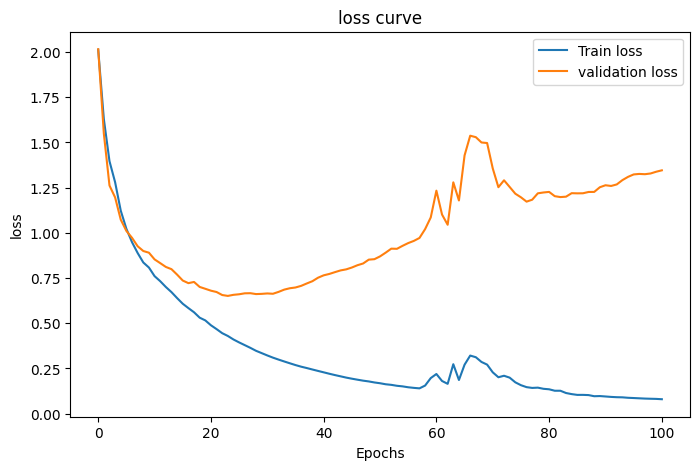

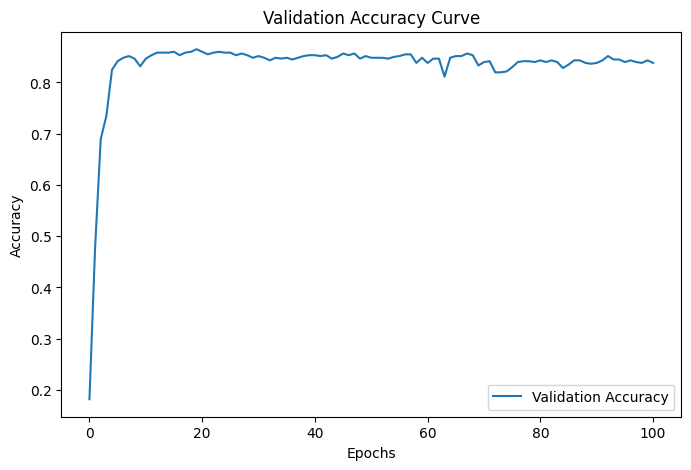

In [18]:
### train the Vanilla GNN model ###
gnn.fit(data, epochs = 100)
acc = gnn.evaluate(data)
print(f'Test Accuracy: {acc * 100:.2f}%')
gnn.plot_loss() 
gnn.plot_accuracy()

<p>We can already see the accuracy of the Vanilla Neural network for the Cora Dataset outperform the MLP</p>

<h5> MLP vs GNN (Vanilla Neural Network)</h5>

<table border="1">
    <tr>
        <th></th>
        <th>MLP</th>
        <th>GNN</th>
    </tr>
    <tr>
        <td>CORA</td>
        <td>71.29%</td>
        <td>80.34%</td>
    </tr>
    <!-- <tr>
        <td>Alice</td>
        <td>24</td>
        <td>Los Angeles</td>
    </tr>
    <tr>
        <td>Bob</td>
        <td>30</td>
        <td>Chicago</td>
    </tr>
    <tr>
        <td>Eve</td>
        <td>22</td>
        <td>Houston</td>
    </tr> -->
</table>

